<a href="https://colab.research.google.com/github/GuQiangJS/finance-tools-py/blob/master/jupyters/%E6%8C%87%E6%A0%87%E7%9B%B8%E5%85%B3%E6%80%A7%E6%B5%8B%E8%AF%95_%E8%B6%8B%E5%8A%BF%E6%80%A7%E6%8C%87%E6%A0%87_DEMA_%E5%8F%8C%E7%A7%BB%E5%8A%A8%E5%B9%B3%E5%9D%87%E7%BA%BF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

~~~ [初步结论](#scrollTo=kubvmEjMJdFz&line=3&uniqifier=1)：当数值>-20时，观察窗口放大时上涨的概率有总体的61.9%上升到74.1%。~~~

## 安装思源字体

这样显示好看点。呵呵！

In [1]:
import os
noto_font_path='/usr/share/fonts/NotoSansCJKsc-Medium.otf'
if not os.path.exists(noto_font_path):
    !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKsc-hinted.zip"
    !unzip "NotoSansCJKsc-hinted.zip"
    !mv NotoSansCJKsc-Medium.otf /usr/share/fonts/
from IPython.display import clear_output
clear_output(True)

--2020-03-16 13:24:49--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKsc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 172.217.203.128, 2607:f8b0:400c:c07::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121063622 (115M) [application/zip]
Saving to: ‘NotoSansCJKsc-hinted.zip’

NotoSansCJKsc-hinte 100%[===================>] 115.46M   104MB/s    in 1.1s    

2020-03-16 13:24:51 (104 MB/s) - ‘NotoSansCJKsc-hinted.zip’ saved [121063622/121063622]

Archive:  NotoSansCJKsc-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansCJKsc-Black.otf  
  inflating: NotoSansCJKsc-Bold.otf  
  inflating: NotoSansCJKsc-DemiLight.otf  
  inflating: NotoSansCJKsc-Light.otf  
  inflating: NotoSansCJKsc-Medium.otf  
  inflating: NotoSansCJKsc-Regular.otf  
  inflating: NotoSansCJKsc-Th

## 安装第三方库。

[talib](https://www.fmz.com/bbs-topic/1234)，[finance-tools-py](https://github.com/GuQiangJS/finance-tools-py)

In [2]:
try:
    import talib
except ModuleNotFoundError:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    import talib
try:
    import finance_tools_py
    from finance_tools_py.simulation import Simulation
    from finance_tools_py.simulation.callbacks import CallBack
    from finance_tools_py.simulation.callbacks.talib import DEMA
    from finance_tools_py.simulation.callbacks import Rolling_Future
except ModuleNotFoundError:
    !pip install git+https://github.com/GuQiangJS/finance-tools-py.git -U
    import finance_tools_py
    from finance_tools_py.simulation import Simulation
    from finance_tools_py.simulation.callbacks import CallBack
    from finance_tools_py.simulation.callbacks.talib import DEMA
    from finance_tools_py.simulation.callbacks import Rolling_Future
clear_output(True)

--2020-03-16 13:25:05--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-03-16 13:25:06--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://managedway.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-03-16 13:25:06--  https://managedway.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving managedway

## 其他相关引用

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
# sns.set()
%matplotlib inline
# plt.rcParams['figure.figsize'] = (18, 6)
plt.style.use('ggplot')

fontprop = matplotlib.font_manager.FontProperties(fname=noto_font_path)
matplotlib.font_manager.fontManager.ttflist += matplotlib.font_manager.createFontList([noto_font_path])
plt.rcParams['font.family'] = fontprop.get_name()

plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

## 读取数据

1. 读取交易日期、开盘价、最高价、最低价、收盘价、成交量。所有数据均取**前复权**数据。

In [0]:
def read_data():
    symbol='600036'
    data=pd.read_csv('https://raw.githubusercontent.com/GuQiangJS/temp/master/600036_daily.csv',parse_dates=True,
                    usecols=['date','open_qfq','high_qfq','low_qfq','close_qfq','volume_qfq'])
    data['date']=pd.to_datetime(data['date'])
    data.rename(columns={'open_qfq':'open','high_qfq':'high','low_qfq':'low','close_qfq':'close','volume_qfq':'volume'},inplace=True)
    data['preclose']=data['close'].shift()
    data['nextclose']=data['close'].shift(-1)
    data['nextchange']=data['nextclose']-data['close']
    data['nextchange_sign']=np.sign(data['nextchange'])
    return data

## 指标应用原则

1. 第一种称为"双线相交法"。就是说，当短期平均线向上穿越长期平均线时，构成买入信号。

    例如：两条平均线分别为5天和20天的移动平均线，或者是10天和40天的移动平均线。在前一种情况下，当5天平均线向上穿越20天平均线后，构成买入信号；而当5天平均线向下穿越20天平均线后，形成卖出信号。系统是连续工作的，即它始终在市，要么处于多头状态，要么处于空头状态。在后一种情况中，当10天平均线向上穿越40天均线时，则为上升趋势信号，当10天平均线向下穿越40天均线时，则为下降趋势信号。同采用单移动平均线法相比，采用双移动平均线法在时间上滞后于市场更多一些，但由此也减少了拉锯现象。

2. 第二种使用双移动平均线的方法。把它们中间看作某种中性区。那么，仅当收市价格同时向上越过了两条平均线之后，才构成买入信号。然后，如果价格再跌回中性区，则上述信号被取消。同样，仅当收市价格同时向下穿越了两条平均线之后，才构成卖出信号。然后，如果价格在涨回两条平均线之间的中性区，我们就平仓了结上述空头头寸。只要价格维持于中性区内，我们就袖手静观。依此方法设计的系统，也有一些其他系统所不及的长处。

    既然两条移动平均线似乎比一条更好，那么，如果把三条平均线相组合，是否能胜过两条平均线的组合呢？基于这样的设想，就有了三重交叉方法。最常用的三重交叉法系统，要数4-9-18天移动平均线的组合。在商品行业，5天、10天和20天移动平均线是使用得最广泛的几种。

    4-9-18天系统其实只是它的一种变化。在使用中，当短期的移动平均线从下往上穿过中期和长期移动平均线时，就构成了买入信号，而中期移动平均线也上穿长期移动平均线时买入信号得到确认；反之，当短期的移动平均线从上往下穿过中期和长期移动平均线时，就构成了卖出信号，而中期移动平均线也下穿长期移动平均线时卖出信号得到确认。
    
    经过实践表明，通过简单移动平均线得到的交易信号比线性加权移动平均线和指数加权移动平均线得到的信号更准确；而利用两条移动平均线进行交易比利用一条或三条移动平均线得到的信号进行交易获利更高。

## 数据处理

计算两条线的上穿和下穿

In [0]:
class Cross_DEMA(CallBack):
    def __init__(self,t1,t2):
        self.t1=t1
        self.t2=t2

    """双线相交法"""
    def on_preparing_data(self, data, **kwargs):
        data['{}日线上穿{}日线'.format(self.t1,self.t2)]=0
        data['{}日线下穿{}日线'.format(self.t1,self.t2)]=0
        #下穿。t1.dema<t2.dema & t1.dema.shift>t2.dema.shift
        data.loc[(data['dema_close_{}'.format(self.t1)]<data['dema_close_{}'.format(self.t2)]) & (data['dema_close_{}'.format(self.t1)].shift()>data['dema_close_{}'.format(self.t2)].shift()),'{}日线下穿{}日线'.format(self.t1,self.t2)]=1
        #上穿。t1.dema>t2.dema & t1.dema.shift<t2.dema.shift
        data.loc[(data['dema_close_{}'.format(self.t1)]>data['dema_close_{}'.format(self.t2)]) & (data['dema_close_{}'.format(self.t1)].shift()<data['dema_close_{}'.format(self.t2)].shift()),'{}日线上穿{}日线'.format(self.t1,self.t2)]=1

class Rolling_Future_New(Rolling_Future):
    def on_preparing_data(self, data, **kwargs):
        super().on_preparing_data(data, **kwargs)
        data['未来{}日涨跌'.format(self.timeperiod)]=np.sign(data['rolling_{}_{}_mean'.format(self.col_name,self.timeperiod)]-data[self.col_name])
        data.rename(columns={'rolling_close_{}_mean/close'.format(self.timeperiod):'未来 {} 日均价/当前'.format(self.timeperiod)},inplace=True)



## 简单绘图示例

时间拉长到30日~60日，看上去还行

In [0]:
import plotly.graph_objects as go

In [7]:
data=read_data()
t1=5
t2=20
s=Simulation(data,'',callbacks=[DEMA(t1),
                DEMA(t2),
                Cross_DEMA(t1,t2)])
s.simulate()

fig = go.Figure()
fig.add_trace(go.Scatter(x=s.data['date'], y=s.data['close'],mode='lines',name='close'))
fig.add_trace(go.Scatter(x=s.data['date'], y=s.data['dema_close_{}'.format(t1)],mode='lines',name='{} 日线'.format(t1)))
fig.add_trace(go.Scatter(x=s.data['date'], y=s.data['dema_close_{}'.format(t2)],mode='lines',name='{} 日线'.format(t2)))

cross_up=s.data.loc[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]
cross_low=s.data.loc[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]

fig.add_trace(go.Scatter(x=cross_up['date'], y=cross_up['close'],mode='markers',marker=dict(color="red",size=6),name='{}日线上穿{}日线'.format(t1,t2)))
fig.add_trace(go.Scatter(x=cross_low['date'], y=cross_low['close'],mode='markers',marker=dict(color="green",size=6),name='{}日线下穿{}日线'.format(t1,t2)))
fig.update_layout(title='{}日线 VS {}日线'.format(t1,t2))

In [8]:
data=read_data()
t1=10
t2=40
s=Simulation(data,'',callbacks=[DEMA(t1),
                DEMA(t2),
                Cross_DEMA(t1,t2)])
s.simulate()

fig = go.Figure()
fig.add_trace(go.Scatter(x=s.data['date'], y=s.data['close'],mode='lines',name='close'))
fig.add_trace(go.Scatter(x=s.data['date'], y=s.data['dema_close_{}'.format(t1)],mode='lines',name='{} 日线'.format(t1)))
fig.add_trace(go.Scatter(x=s.data['date'], y=s.data['dema_close_{}'.format(t2)],mode='lines',name='{} 日线'.format(t2)))

cross_up=s.data.loc[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]
cross_low=s.data.loc[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]

fig.add_trace(go.Scatter(x=cross_up['date'], y=cross_up['close'],mode='markers',marker=dict(color="red",size=6),name='{}日线上穿{}日线'.format(t1,t2)))
fig.add_trace(go.Scatter(x=cross_low['date'], y=cross_low['close'],mode='markers',marker=dict(color="green",size=6),name='{}日线下穿{}日线'.format(t1,t2)))
fig.update_layout(title='{}日线 VS {}日线'.format(t1,t2))

In [9]:


data=read_data()
t1=30
t2=120
s=Simulation(data,'',callbacks=[DEMA(t1),
                DEMA(t2),
                Cross_DEMA(t1,t2)])
s.simulate()

fig = go.Figure()
fig.add_trace(go.Scatter(x=s.data['date'], y=s.data['close'],mode='lines',name='close'))
fig.add_trace(go.Scatter(x=s.data['date'], y=s.data['dema_close_{}'.format(t1)],mode='lines',name='{} 日线'.format(t1)))
fig.add_trace(go.Scatter(x=s.data['date'], y=s.data['dema_close_{}'.format(t2)],mode='lines',name='{} 日线'.format(t2)))

cross_up=s.data.loc[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]
cross_low=s.data.loc[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]

fig.add_trace(go.Scatter(x=cross_up['date'], y=cross_up['close'],mode='markers',marker=dict(color="red",size=6),name='{}日线上穿{}日线'.format(t1,t2)))
fig.add_trace(go.Scatter(x=cross_low['date'], y=cross_low['close'],mode='markers',marker=dict(color="green",size=6),name='{}日线下穿{}日线'.format(t1,t2)))
fig.update_layout(title='{}日线 VS {}日线'.format(t1,t2))


In [10]:
data=read_data()
t1=60
t2=240
s=Simulation(data,'',callbacks=[DEMA(t1),
                DEMA(t2),
                Cross_DEMA(t1,t2)])
s.simulate()

fig = go.Figure()
fig.add_trace(go.Scatter(x=s.data['date'], y=s.data['close'],mode='lines',name='close'))
fig.add_trace(go.Scatter(x=s.data['date'], y=s.data['dema_close_{}'.format(t1)],mode='lines',name='{} 日线'.format(t1)))
fig.add_trace(go.Scatter(x=s.data['date'], y=s.data['dema_close_{}'.format(t2)],mode='lines',name='{} 日线'.format(t2)))

cross_up=s.data.loc[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]
cross_low=s.data.loc[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]

fig.add_trace(go.Scatter(x=cross_up['date'], y=cross_up['close'],mode='markers',marker=dict(color="red",size=6),name='{}日线上穿{}日线'.format(t1,t2)))
fig.add_trace(go.Scatter(x=cross_low['date'], y=cross_low['close'],mode='markers',marker=dict(color="green",size=6),name='{}日线下穿{}日线'.format(t1,t2)))
fig.update_layout(title='{}日线 VS {}日线'.format(t1,t2))

## 双线相交法 初测

都不是那么有用

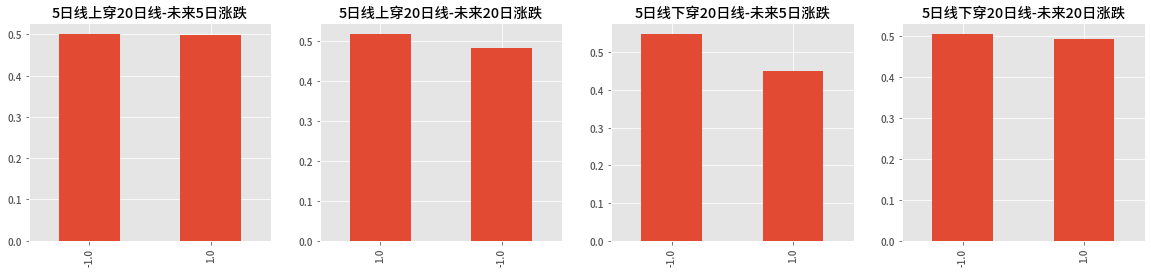

In [84]:
data=read_data()
t1=5
t2=20
s=Simulation(data,'',callbacks=[DEMA(t1),
                DEMA(t2),
                Cross_DEMA(t1,t2),
                Rolling_Future_New(timeperiod=t1),
                Rolling_Future_New(timeperiod=t2)])
s.simulate()

fig,axes=plt.subplots(1,4,figsize=(20,4))
vcs=s.data[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t1)].value_counts(normalize=True)
vcs.plot(ax=axes[0],kind='bar',title='{0}日线上穿{1}日线-未来{0}日涨跌'.format(t1,t2))
vcs=s.data[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t2)].value_counts(normalize=True)
vcs.plot(ax=axes[1],kind='bar',title='{0}日线上穿{1}日线-未来{1}日涨跌'.format(t1,t2))

vcs=s.data[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t1)].value_counts(normalize=True)
vcs.plot(ax=axes[2],kind='bar',title='{0}日线下穿{1}日线-未来{0}日涨跌'.format(t1,t2))
vcs=s.data[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t2)].value_counts(normalize=True)
vcs.plot(ax=axes[3],kind='bar',title='{0}日线下穿{1}日线-未来{1}日涨跌'.format(t1,t2))

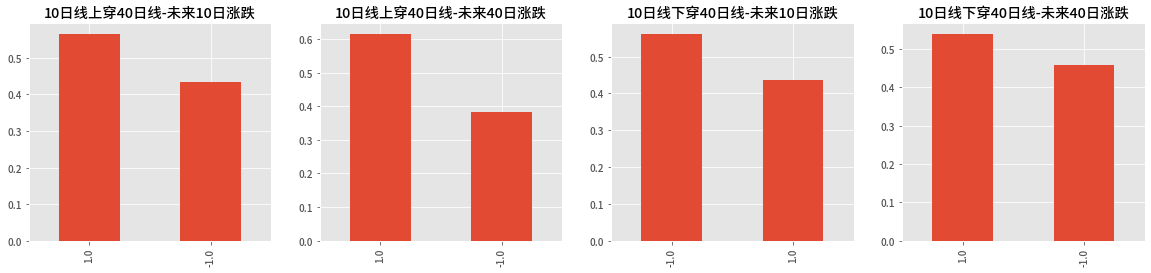

In [85]:
data=read_data()
t1=10
t2=40
s=Simulation(data,'',callbacks=[DEMA(t1),
                DEMA(t2),
                Cross_DEMA(t1,t2),
                Rolling_Future_New(timeperiod=t1),
                Rolling_Future_New(timeperiod=t2)])
s.simulate()

fig,axes=plt.subplots(1,4,figsize=(20,4))
vcs=s.data[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t1)].value_counts(normalize=True)
vcs.plot(ax=axes[0],kind='bar',title='{0}日线上穿{1}日线-未来{0}日涨跌'.format(t1,t2))
vcs=s.data[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t2)].value_counts(normalize=True)
vcs.plot(ax=axes[1],kind='bar',title='{0}日线上穿{1}日线-未来{1}日涨跌'.format(t1,t2))

vcs=s.data[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t1)].value_counts(normalize=True)
vcs.plot(ax=axes[2],kind='bar',title='{0}日线下穿{1}日线-未来{0}日涨跌'.format(t1,t2))
vcs=s.data[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t2)].value_counts(normalize=True)
vcs.plot(ax=axes[3],kind='bar',title='{0}日线下穿{1}日线-未来{1}日涨跌'.format(t1,t2))

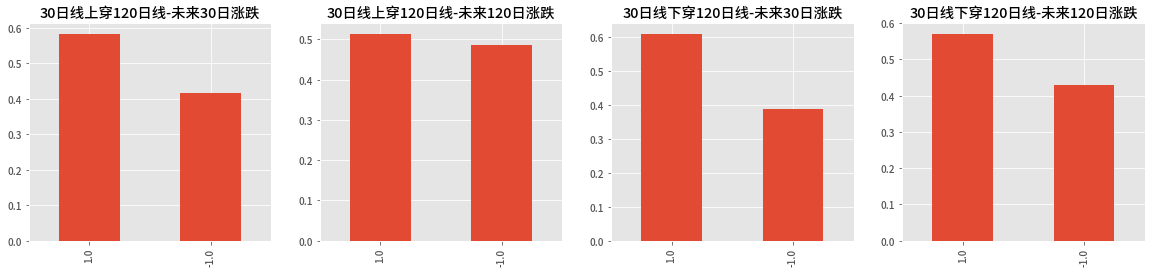

In [92]:
data=read_data()
t1=30
t2=120
s=Simulation(data,'',callbacks=[DEMA(t1),
                DEMA(t2),
                Cross_DEMA(t1,t2),
                Rolling_Future_New(timeperiod=t1),
                Rolling_Future_New(timeperiod=t2)])
s.simulate()

fig,axes=plt.subplots(1,4,figsize=(20,4))
vcs=s.data[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t1)].value_counts(normalize=True)
vcs.plot(ax=axes[0],kind='bar',title='{0}日线上穿{1}日线-未来{0}日涨跌'.format(t1,t2))
vcs=s.data[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t2)].value_counts(normalize=True)
vcs.plot(ax=axes[1],kind='bar',title='{0}日线上穿{1}日线-未来{1}日涨跌'.format(t1,t2))

vcs=s.data[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t1)].value_counts(normalize=True)
vcs.plot(ax=axes[2],kind='bar',title='{0}日线下穿{1}日线-未来{0}日涨跌'.format(t1,t2))
vcs=s.data[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t2)].value_counts(normalize=True)
vcs.plot(ax=axes[3],kind='bar',title='{0}日线下穿{1}日线-未来{1}日涨跌'.format(t1,t2))

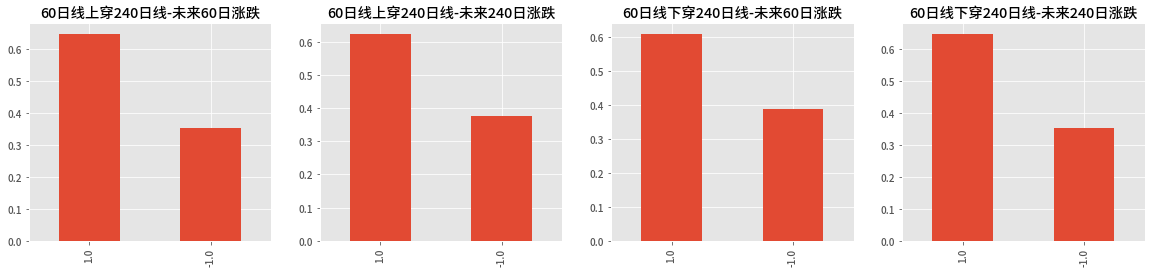

In [93]:
data=read_data()
t1=60
t2=240
s=Simulation(data,'',callbacks=[DEMA(t1),
                DEMA(t2),
                Cross_DEMA(t1,t2),
                Rolling_Future_New(timeperiod=t1),
                Rolling_Future_New(timeperiod=t2)])
s.simulate()

fig,axes=plt.subplots(1,4,figsize=(20,4))
vcs=s.data[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t1)].value_counts(normalize=True)
vcs.plot(ax=axes[0],kind='bar',title='{0}日线上穿{1}日线-未来{0}日涨跌'.format(t1,t2))
vcs=s.data[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t2)].value_counts(normalize=True)
vcs.plot(ax=axes[1],kind='bar',title='{0}日线上穿{1}日线-未来{1}日涨跌'.format(t1,t2))

vcs=s.data[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t1)].value_counts(normalize=True)
vcs.plot(ax=axes[2],kind='bar',title='{0}日线下穿{1}日线-未来{0}日涨跌'.format(t1,t2))
vcs=s.data[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['未来{}日涨跌'.format(t2)].value_counts(normalize=True)
vcs.plot(ax=axes[3],kind='bar',title='{0}日线下穿{1}日线-未来{1}日涨跌'.format(t1,t2))

## 回测

每次最多买当前剩余资金的1/5。卖出所有，自2002年~2019年之间，资金增长164.23%。比总涨幅少多了。

In [0]:
from tqdm.auto import tqdm
import datetime

from finance_tools_py.backtest import BackTest
from finance_tools_py.backtest import AllInChecker

class Checker(AllInChecker):
    
    def on_calc_buy_amount(self,
                           date: datetime.datetime.timestamp,
                           code: str,
                           price: float,
                           cash: float) -> float:
        # 每次最多买1/5
        return super().on_calc_buy_amount(date,code,price,cash*0.25)

    def on_check_sell(self,
                      date: datetime.datetime.timestamp,
                      code: str,
                      price: float,
                      cash: float,
                      hold_amount: float,
                      hold_price: float) -> bool:
        """当 `date` 及 `code` 包含在参数 :py:attr:`sell_dict` 中时返回 `True` 。否则返回 `False` 。"""
        if hold_amount>0 and hold_price*1.15>price:
            return False
        if code in self.sell_dict.keys() and date in self.sell_dict[code]:
            return True
        else:
            return False


### 5日 vs 20日 **卧草**

交易95次，资金变化率 766.55%

In [39]:
data=read_data()
t1=5
t2=20
s=Simulation(data,'',callbacks=[DEMA(t1),
                DEMA(t2),
                Cross_DEMA(t1,t2),
                Rolling_Future_New(timeperiod=t1),
                Rolling_Future_New(timeperiod=t2)])
s.simulate()
s.data.loc[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['date'].values
symbol='600036'
s.data['code']=symbol
buy=s.data[s.data['date']<'2019-01-01'].loc[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['date']
sell=s.data.loc[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]['date']

bt = BackTest(s.data, init_cash=10000, callbacks=[Checker(
     buy_dict={symbol: buy.dt.to_pydatetime()},
     sell_dict={symbol: sell.dt.to_pydatetime()})])
bt.calc_trade_history(verbose=0)
print(bt.report())


数据时间:2002-04-09 00:00:00~2019-12-31 00:00:00（可交易天数4236）
初始资金:10000.00
交易次数:95 (买入/卖出各算1次)
可用资金:76655.21
当前持仓:无
当前总资产:76655.21
资金变化率:766.55%
资产变化率:766.55%
总手续费:855.57
总印花税:671.48
交易历史：
     datetime    code      price  amount          cash  commission        tax         total  toward
0  2002-07-11  600036   2.279672  1000.0   7713.048269    5.000000   2.279672   2286.951731       1
1  2002-09-05  600036   2.163549   800.0   5975.477946    5.000000   1.730839   1737.570323       1
2  2002-09-27  600036   2.053538   700.0   4531.563611    5.000000   1.437477   1443.914336       1
3  2002-11-14  600036   1.929267   500.0   3560.965626    5.000000   0.964633    970.597985       1
4  2002-12-10  600036   1.770362   400.0   2847.112702    5.000000   0.708145    713.852924       1
5  2002-12-27  600036   1.713319   400.0   2156.099688    5.000000   0.685328    691.013014       1
6  2003-02-12  600036   1.961863   200.0   1758.334806    5.000000   0.392373    397.764882       1
7  2003-04-21  

### 10日 VS 40日 **卧草**

交易64次，资金变化率 568.58%

In [40]:
data=read_data()
t1=10
t2=40
s=Simulation(data,'',callbacks=[DEMA(t1),
                DEMA(t2),
                Cross_DEMA(t1,t2),
                Rolling_Future_New(timeperiod=t1),
                Rolling_Future_New(timeperiod=t2)])
s.simulate()
s.data.loc[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['date'].values
symbol='600036'
s.data['code']=symbol
buy=s.data[s.data['date']<'2019-01-01'].loc[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['date']
sell=s.data.loc[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]['date']

bt = BackTest(s.data, init_cash=10000, callbacks=[Checker(
     buy_dict={symbol: buy.dt.to_pydatetime()},
     sell_dict={symbol: sell.dt.to_pydatetime()})])
bt.calc_trade_history(verbose=0)
print(bt.report())


数据时间:2002-04-09 00:00:00~2019-12-31 00:00:00（可交易天数4236）
初始资金:10000.00
交易次数:64 (买入/卖出各算1次)
可用资金:56857.83
当前持仓:无
当前总资产:56857.83
资金变化率:568.58%
资产变化率:568.58%
总手续费:497.37
总印花税:371.71
交易历史：
     datetime    code      price  amount          cash  commission        tax         total  toward
0  2002-11-15  600036   1.915006  1300.0   7503.002667    5.000000   2.489508   2496.997333       1
1  2002-12-27  600036   1.713319  1000.0   5782.970133    5.000000   1.713319   1720.032534       1
2  2003-03-10  600036   1.870187   700.0   4467.530291    5.000000   1.309131   1315.439841       1
3  2003-05-21  600036   2.454875   400.0   3479.598446    5.000000   0.981950    987.931845       1
4  2003-07-15  600036   2.452837 -3400.0  11802.566642    8.339647   8.339647   8356.326785      -1
5  2003-07-22  600036   2.399336  1200.0   8915.484227    5.000000   2.879203   2887.082414       1
6  2003-11-17  600036   1.889014  1100.0   6830.490787    5.000000   2.077916   2084.993440       1
7  2004-02-12  

### 30日 VS 120日 **卧草**

交易35次，资金变化率 339.00%

In [41]:
data=read_data()
t1=30
t2=120
s=Simulation(data,'',callbacks=[DEMA(t1),
                DEMA(t2),
                Cross_DEMA(t1,t2),
                Rolling_Future_New(timeperiod=t1),
                Rolling_Future_New(timeperiod=t2)])
s.simulate()
s.data.loc[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['date'].values
symbol='600036'
s.data['code']=symbol
buy=s.data[s.data['date']<'2019-01-01'].loc[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['date']
sell=s.data.loc[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]['date']

bt = BackTest(s.data, init_cash=10000, callbacks=[Checker(
     buy_dict={symbol: buy.dt.to_pydatetime()},
     sell_dict={symbol: sell.dt.to_pydatetime()})])
bt.calc_trade_history(verbose=0)
print(bt.report())


数据时间:2002-04-09 00:00:00~2019-12-31 00:00:00（可交易天数4236）
初始资金:10000.00
交易次数:35 (买入/卖出各算1次)
可用资金:33900.16
当前持仓:无
当前总资产:33900.16
资金变化率:339.00%
资产变化率:339.00%
总手续费:230.91
总印花税:146.89
交易历史：
     datetime    code      price  amount          cash  commission        tax         total  toward
0  2003-07-01  600036   2.318380  1000.0   7674.301993    5.000000   2.318380   2325.698007       1
1  2003-07-23  600036   2.384932   800.0   5759.448638    5.000000   1.907945   1914.853355       1
2  2004-03-10  600036   2.271756   600.0   4390.032263    5.000000   1.363053   1369.416374       1
3  2004-09-14  600036   2.226881   400.0   3493.388951    5.000000   0.890753    896.643312       1
4  2004-10-19  600036   2.206954   300.0   2825.640651    5.000000   0.662086    667.748301       1
5  2005-03-22  600036   2.102335   300.0   2189.309312    5.000000   0.630701    636.331338       1
6  2005-05-27  600036   2.109808   200.0   1761.925707    5.000000   0.421962    427.383605       1
7  2005-09-27  